In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import time
import optax
import matplotlib.pyplot as plt 
from jax.flatten_util import ravel_pytree
from functools import partial
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import piml_library.lagrangian as lag
import piml_library.hamiltonian as ham
import piml_library.util as util
import piml_library.early_stopping as es
import piml_library.plotting as plotting
from piml_library.bnn_l import (
    BaselineNN_l, 
    compute_loss, 
    train_step, 
    create_trajectory,
)
import dataset_generator as dg

In [2]:
@jax.jit
#L((t, q, v))
def L_analytical(state):
    q = lag.coordinate(state)
    v = lag.velocity(state)
    q_flat, _ = ravel_pytree(q)
    v_flat, _ = ravel_pytree(v)
    
    T = 0.5 * jnp.sum(v_flat**2)
    V = 0.5 * jnp.sum(q_flat**2)
    return T - V

In [3]:
@jax.jit
#H((t, q, p))
def H_analytical(state, m=1.0, k=1.0):
    q = ham.coordinate(state) 
    p = ham.momentum(state) 
    
    q_flat, _ = ravel_pytree(q) 
    p_flat, _ = ravel_pytree(p) 
    
    T = 0.5 / m * jnp.sum(p_flat**2) 
    V = 0.5 * k * jnp.sum(q_flat**2) 
    return T + V 

In [4]:
# --- ハイパーパラメータ ---
q_dim = 1      
hidden_dim = 200
learning_rate = 1e-3
num_epochs = 2000
key = jax.random.PRNGKey(0)
optimizer = optax.adamw(learning_rate, weight_decay=1e-4)

num_trajectories = 50       # 合計50本生成する
test_split_ratio = 0.5      # 半分(25本)をテストにする
N_points_per_traj = 30      # 1軌道あたり30点 (論文の設定)
t_end = 3.0

--- 学習用・テスト用データセットの生成開始 ---
Generating 50 independent trajectories...
Splitting: 25 Train trajectories / 25 Test trajectories
--- データセット生成完了 ---
Total Train Points: 750
Total Test Points:  750


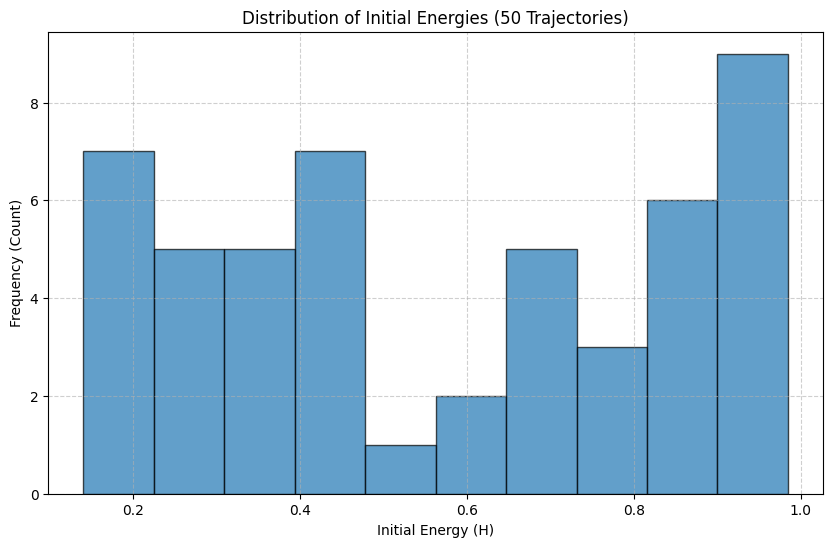

In [5]:
data_dict = dg.create_trajectory_datasets(
    L_analytical, 
    H_analytical,
    key,
    q_dim=q_dim,
    num_trajectories=num_trajectories,
    N_points_per_traj=N_points_per_traj,
    t_end=t_end,
    test_split_ratio=test_split_ratio, # 引数名が変わりました
    noise_std=0.1
)

train_states = data_dict["train_states_lnn"]
train_t, train_q, train_p = train_states
train_targets = data_dict["train_targets_lnn"]
test_dataset_states = data_dict["test_dataset_states_lnn"]
test_dataset_targets = data_dict["test_dataset_targets_lnn"]
initial_energies = data_dict["initial_energies"]
N_train_total = data_dict["N_train_total"]

key, _ = jax.random.split(key) 

# --- エネルギー分布の可視化 ---
energies_np = np.array(initial_energies)

plt.figure(figsize=(10, 6))
plt.hist(energies_np, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Initial Energy (H)')
plt.ylabel('Frequency (Count)')
plt.title(f'Distribution of Initial Energies ({num_trajectories} Trajectories)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [6]:
'''
learning Process
'''
# --- モデルとオプティマイザの初期化 ---
bnn_model = BaselineNN_l(hidden_dim=hidden_dim, output_dim=q_dim)
model_apply_fn = bnn_model.apply

key, init_key = jax.random.split(key)

dummy_q = jnp.zeros((q_dim,))
dummy_v = jnp.zeros((q_dim,))
dummy_state = (0.0, dummy_q, dummy_v)

params = bnn_model.init(init_key, dummy_state)['params'] 
opt_state = optimizer.init(params) 

print("モデルとオプティマイザの初期化完了。学習を開始します...")

start_train_time = time.time()

train_loss_history = []
test_loss_history = []
best_test_loss = float('inf') 
best_params = params  
best_epoch = 0

# --- 学習ループ ---
for epoch in range(num_epochs):
    
    params, opt_state, train_loss = train_step(
        params, 
        opt_state, 
        optimizer, 
        model_apply_fn, 
        train_states, 
        train_targets  
    )
    test_loss = compute_loss(
        params,
        model_apply_fn,
        test_dataset_states,
        test_dataset_targets
    )
    
    train_loss_history.append(float(train_loss))
    test_loss_history.append(float(test_loss))
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_epoch = epoch
        best_params = params
        
    if epoch % 100 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")

print("学習完了。")

# Final Test Loss
best_test_loss = compute_loss(best_params, model_apply_fn, test_dataset_states, test_dataset_targets)
best_test_loss.block_until_ready()
end_train_time = time.time()
print(f"--- Final Test Loss: {best_test_loss:.6f} ---")
print(f"--- Total Training Time: {end_train_time - start_train_time:.2f} seconds ---")

モデルとオプティマイザの初期化完了。学習を開始します...
Epoch 0, Train Loss: 230.941833, Test Loss: 1201.408447
Epoch 100, Train Loss: 0.521584, Test Loss: 0.487181
Epoch 200, Train Loss: 0.080571, Test Loss: 0.065989
Epoch 300, Train Loss: 0.028304, Test Loss: 0.026753
Epoch 400, Train Loss: 0.023686, Test Loss: 0.024764
Epoch 500, Train Loss: 0.022458, Test Loss: 0.024033
Epoch 600, Train Loss: 0.021389, Test Loss: 0.023060
Epoch 700, Train Loss: 0.020339, Test Loss: 0.022037
Epoch 800, Train Loss: 0.019324, Test Loss: 0.021029
Epoch 900, Train Loss: 0.018359, Test Loss: 0.020059
Epoch 1000, Train Loss: 0.017453, Test Loss: 0.019137
Epoch 1100, Train Loss: 0.016611, Test Loss: 0.018268
Epoch 1200, Train Loss: 0.015833, Test Loss: 0.017456
Epoch 1300, Train Loss: 0.015121, Test Loss: 0.016701
Epoch 1400, Train Loss: 0.014473, Test Loss: 0.016003
Epoch 1500, Train Loss: 3.209067, Test Loss: 6.336230
Epoch 1600, Train Loss: 0.017036, Test Loss: 0.018691
Epoch 1700, Train Loss: 0.013445, Test Loss: 0.014909
Epoch

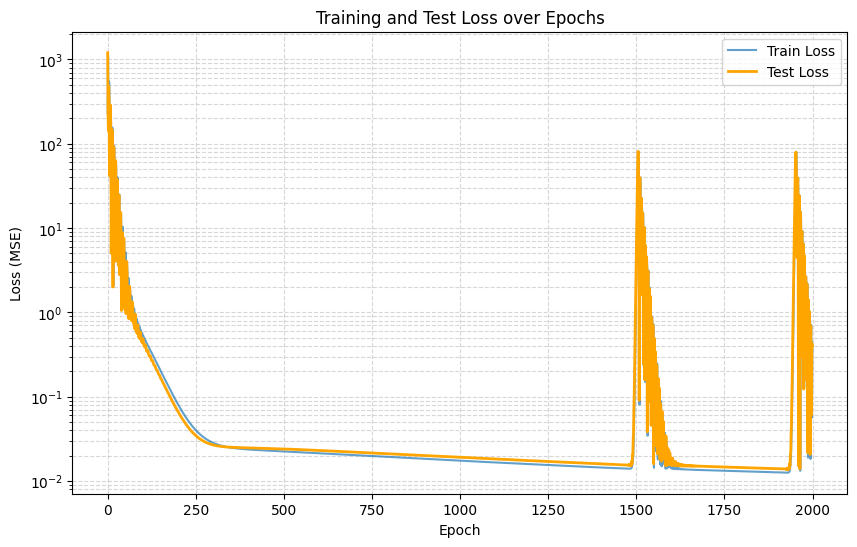

In [7]:
# --- Lossの可視化 ---
plt.figure(figsize=(10, 6))

plt.plot(train_loss_history, label='Train Loss', alpha=0.7)
plt.plot(test_loss_history, label='Test Loss', linewidth=2, color='orange')

plt.yscale('log')  # 縦軸を対数表示にする
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

In [8]:
'''
generate trajectory
'''
#ham_to_lgr_state_fn = ham.hamiltonian_state_to_lagrangian_state(H_analytical)
lag_to_ham_state_fn = ham.lagrangian_state_to_hamiltonian_state(L_analytical)

solver_learned = create_trajectory(model_apply_fn, best_params)

initial_states_list = [
    (0.0, jnp.array([jnp.sqrt(0.2*(i+1))]), jnp.array([0.0]))  #H=[0.1, 1.0]の等間隔10点を初期値とする
    for i in range(10)
]
list_extrapolation = [
    (0.0, jnp.array([jnp.sqrt(0.1)]),  jnp.array([0.0])),
    (0.0, jnp.array([jnp.sqrt(2.1)]),  jnp.array([0.0])),
    (0.0, jnp.array([jnp.sqrt(4.0)]), jnp.array([0.0]))
]
#外挿データを結合する
initial_states_list += list_extrapolation

results_all = []
t_eval = jnp.linspace(0.0, 50.0, 5000) 

for i, initial_state in enumerate(initial_states_list):
    #true
    ds_true = lag.state_derivative(L_analytical)
    solver_true = util.ode_solver(ds_true)
    lag_states_true = solver_true(initial_state, t_eval)
    ham_states_true = jax.vmap(lag_to_ham_state_fn)(lag_states_true)

    lag_states_learned = solver_learned(initial_state, t_eval)
    ham_states_learned = jax.vmap(lag_to_ham_state_fn)(lag_states_learned)
    res = {
        "id": i,
        "initial_state": initial_state,
        
        # Trueの結果 (ham_states, lag_states)
        "true": (ham_states_true, lag_states_true),
        
        # LNNの結果
        "bnn": (ham_states_learned, lag_states_learned)
    }
    results_all.append(res)

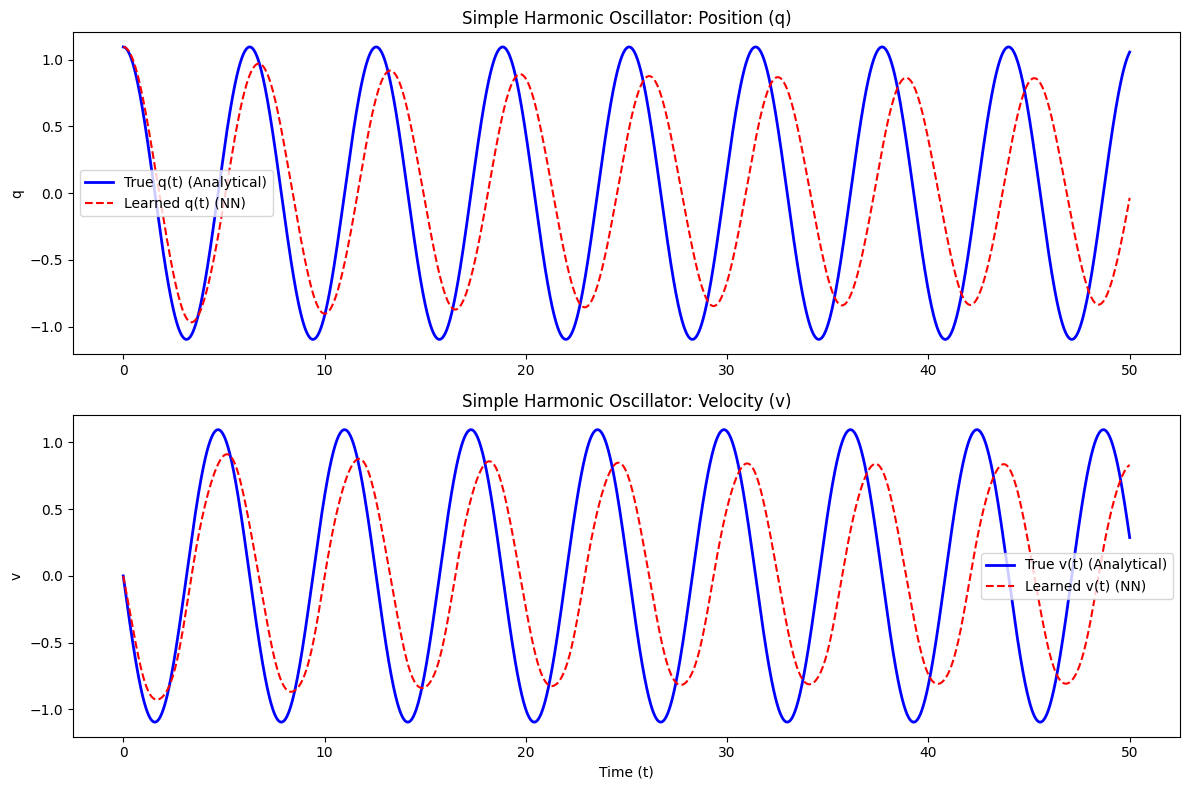

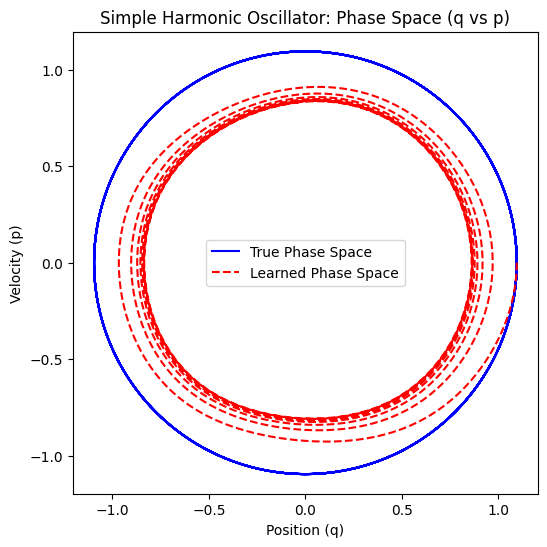

In [9]:
''' 
plot result
'''
# 図示したいデータのインデックスを指定
target_id = 5
res = results_all[target_id]
# True
ham_states_true, lag_states_true = res["true"]
t_true, q_true, p_true = ham_states_true
v_true = lag_states_true[2]

# BNN
ham_states_learned, lag_states_learned = res["bnn"]
t_learned, q_learned, p_learned = ham_states_learned
v_learned = lag_states_learned[2]

title_prefix="Simple Harmonic Oscillator:"
plotting.plot_trajectory_comparison(
    t_true, q_true, v_true, 
    t_learned, q_learned, v_learned,
    title_prefix
)

plotting.plot_phase_space(
    q_true, p_true, 
    q_learned, p_learned,
    title_prefix
    )

In [10]:
# データを保存
t_bnn_list, q_bnn_list, p_bnn_list, v_bnn_list = [], [], [], []

# results_all から各軌道データを抽出してリストに追加
for res in results_all:

    ham, lag = res["bnn"]
    t_bnn_list.append(ham[0])
    q_bnn_list.append(ham[1])
    p_bnn_list.append(ham[2])
    v_bnn_list.append(lag[2])

np.savez(
    "results_H1D_NN_l.npz", 
    # BNN
    t_learned=np.array(t_bnn_list),
    q_learned=np.array(q_bnn_list),
    v_learned=np.array(v_bnn_list),
    p_learned=np.array(p_bnn_list),
)